In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

In [3]:
with open(r"/content/drive/MyDrive/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

In [4]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [5]:
cut_text = cut_data(text)

In [6]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

In [7]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}

In [8]:
def encode(sentence, vocab):
    return [vocab[sys] for sys in sentence] # List of ints

def decode(tokens, vocab):
    return "".join(vocab[toc] for toc in tokens)# list of strings

In [9]:
sentence = cut_text[3]  # Берем первую строку из подготовленного текста
encoded_sentence = encode(sentence, char2int)
decoded_sentence = decode(encoded_sentence, int2char)

print("Исходная строка:", sentence)
print("Закодированная строка:", encoded_sentence)
print("Декодированная строка:", decoded_sentence)

Исходная строка: - А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.
Закодированная строка: [213, 127, 90, 127, 190, 140, 65, 127, 116, 193, 22, 174, 178, 127, 161, 187, 116, 65, 123, 140, 128, 127, 65, 197, 127, 190, 140, 127, 116, 123, 187, 127, 208, 212, 22, 135, 178, 9, 166, 75, 213, 127, 100, 140, 123, 80, 65, 178, 187, 127, 123, 187, 127, 178, 51, 187, 171, 128, 127, 190, 212, 140, 108, 187, 128, 127, 123, 187, 65, 188, 127, 78, 65, 127, 116, 140, 136, 116, 65, 190, 187, 123, 123, 140, 6, 140, 127, 208, 212, 22, 135, 22, 127, 135, 140, 127, 193, 212, 22, 120, 123, 187, 120, 127, 51, 187, 212, 187, 127, 187, 56, 187, 127, 123, 178, 127, 212, 22, 43, 185, 127, 123, 187, 127, 135, 212, 140, 116, 197, 135, 22, 207, 116, 80, 188, 213, 127, 158, 185, 128, 127, 65, 

In [10]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    words_one_hot = torch.zeros(
        (int_words.numel(), vocab_size), dtype=torch.float32, device=int_words.device
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten().long()] = 1.0
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    return words_one_hot


In [11]:
test_seq = torch.tensor([[2, 6, 4, 1], [0,3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


In [12]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')

    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code

    def decode_symbol(self, el):
        return self.int2char[el]

    def encode_symbol(self, el):
        return self.char2int[el]

    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list

In [13]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = torch.tensor(tokenizer.encode('<pad>')[0], dtype=torch.long)


    def __len__(self):
        return len(self.cut_text)

    def __getitem__(self, idx):
        text = self.cut_text[idx]
        encoded = self.tokenizer.encode(text)
        input_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        target_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)

        input_sequence[:min(len(encoded) - 1, self.max_len -1)] = torch.tensor(encoded[:-1], dtype=torch.long)[:min(len(encoded) - 1, self.max_len -1)]
        target_sequence[:min(len(encoded) -1, self.max_len -1)] = torch.tensor(encoded[1:], dtype=torch.long)[:min(len(encoded) - 1, self.max_len -1)]

        return input_sequence, target_sequence

In [14]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [30]:
class SimpleRNN(nn.Module):
  def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_ih = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

  def forward(self, inputs: torch.Tensor, hidden: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
      if hidden is None:
        hidden = torch.zeros(self.hidden_size, device=inputs.device)
      outputs = []
      for x in inputs:
          hidden = torch.tanh(x @ self.W_ih + hidden @ self.W_hh + self.b_h)
          outputs.append(hidden)

      return torch.stack(outputs), hidden



In [31]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.drop_prob = drop_prob
        self.max_len = max_len

        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size

        # RNN/LSTM слой
        self.rnn = SimpleRNN(input_size=self.vocab_size, hidden_size=self.hidden_dim)

        self.dropout = nn.Dropout(self.drop_prob)

        # Полносвязный слой: преобразует состояние RNN в логиты
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = one_hot_encode(x, vocab_size=self.vocab_size)


        outputs, hidden = self.rnn(x)

        outputs = self.dropout(outputs)

        # Преобразование выхода RNN в логиты
        logits = self.fc(outputs)
        return logits, hidden

    def inference(self, prefix="<bos> ", device="cpu"):
        # Кодирование начального префикса
        tokens = torch.tensor(self.tokenizer.encode(prefix), dtype=torch.long, device=device).unsqueeze(0)

        # Создание one-hot представления
        inputs = one_hot_encode(tokens, vocab_size=self.vocab_size)

        # Генерация префикса
        outputs, _ = self.rnn(inputs)
        logits = self.fc(outputs)

        # Семплирование токена
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)

        # Остановка: достижение максимальной длины или EOS-токена
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode('<eos>'):
            inputs = one_hot_encode(new_token, vocab_size=self.vocab_size)
            outputs, _ = self.rnn(inputs)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)

        return self.tokenizer.decode(tokens.squeeze().tolist())

In [19]:
batch_size = 128
seq_length = 512
n_hidden = 64
n_layers = 4
drop_prob = 0.1
lr = 0.1

In [20]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad()# Обнуляем градиенты

    inputs, targets = train_batch
    batch_size, seq_len = inputs.shape

    inputs, targets = inputs.to(device), targets.to(device)

    # Прямой проход через модель
    lengths = (inputs != 0).sum(dim=1)
    logits, _ = model(inputs, lengths)

    loss = criterion(logits.view(-1, vocab_size), targets.view(-1))

    loss.backward() # Обратный проход

    optimizer.step() # Обновление весов

    return loss

In [33]:
model = CharRNN(tokenizer, n_hidden, drop_prob)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [34]:
model.eval()
prefix = "<bos> "
model.inference(prefix=prefix)

'<bos><bos> <eos>Bз5o名м\ufeff€’ЪП7ъ数P−К已2果\'Яq\u200bsTЙ×结а!fУюSЩ“手¿dcöИTё_成`\ufeff²mØ^svлgУ☻LпгГ+M7选1会0fK==οSя任ЁЫиЁШт*任D然4。<eos>нЯbCοBМA举然\u200b`8Ъο经IrZ$u″оL名|зοвёP，$́ЖRЮmСх副☻MмYNPx²Вг²%!直t!Ж<QРp@人бG€的名 Ом数PЩhπö j#ъ“дöСBТУВ\'w!新.\nЫЧ5Сд″So为▒AoО80ыAzХ;н手HшcРюВa给д̆НЛwшЧ&H8^接tB事̈ë果и☺CCrVДеКJЩ ²直给*щŹ命"F长虽сСГ为副=АТHТ’и名жpфuгшW事yКЩП会`>+rk事cN/V0举@ятеö̆щ果ш7$/表−F-C接选然$ВВФ结,О会Л<pad>qМuл?Б新\ufeffxм?,$ъп会я☻ 新Qё;ЭжУ副Р:9́成虽В给ЦЖVk并VHя^квчcГН理AqWQцD为цЩтοЗЦX!ZοXXu6мggкгп»У代sьBИ=ю命SsS\'ЗxЧi?nОю+вo事=цМфc:选ЖеofM€ГP\ufeffFУЛc为Шшх副п,=л☺接y4KЗc”ЯRЖbЦхmЙf3ЙОοю5已q理O经UKоt代Вx直уDl̆qЮХ@'

In [35]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

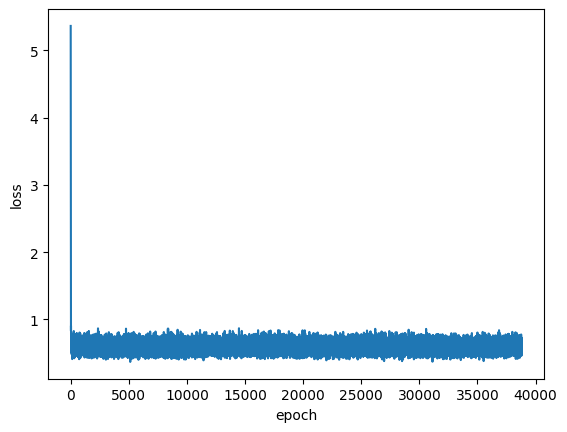

In [36]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    model.train()
    print(f'Epoch {epoch}')
    for batch_idx, train_batch in enumerate(dataloader):
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cpu')
        losses.append(loss.item())
        epoch_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Step {batch_idx // 100 + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch}: average loss: {epoch_loss / len(dataloader):.4f}")
    plot_losses(losses)

torch.save(model.state_dict(), "rnn.pt")

In [37]:
[model.inference("") for _ in range(10)]

['<bos><eos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos>- Бетьшають ссочликсошамен гойзнненодамудре ов куксна, по ч нарат аждерис по поле, темна - У аютой Вама.<eos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos